In [1]:
import numpy as np
import hickle as hkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rs
import os
import sys
import boto3
import yaml

sys.path.append('../src/')
from utils import quick_viz as make
%load_ext autoreload
%autoreload 2

## Conclusions
- A total of 255 tiles are affected by haze.
- In areas where resegmentation did not help the predictions, we expect the features to play a role. This notebook visualizes 65 features for neighboring haze affected tiles where resegmentation appeared successful (pd_east) and unsuccessful (pd_west).
- Artifacts are most extreme for the following feature indices pd_east: `10, 17, 19, 20, 31` and pd_west: `17, 19, 20, 23, 25, 28, 29, 31, 32, 40`. 
- The top 40 features used in the current model includes feature `42` which had strong artifacts in pd_west

## Example: resegmentation is successful

### ARD

In [5]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
for i in range(0, 13):
    make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

In [7]:
tile_idx_a = (1656, 1068)
tile_idx_b = (1657, 1068)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

In [9]:
for i in range(0, 65):
    make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

/Users/jessica.ertel/github/plantation_classifier/notebooks/../src/utils/quick_viz.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,3))


Error in callback <function _draw_all_if_interactive at 0x166fcaef0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x16f992680> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



## Example: resegmentation is unsuccessful

### ARD

In [11]:
# tile_idx_a = (1647, 1079)
# tile_idx_b = (1648, 1079)
# ard_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/ard/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_ard.hkl')
# ard_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/ard/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_ard.hkl')
# for i in range(0, 5):
#     make.heat_combine_neighbors(ard_a, ard_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

### Features

In [34]:
tile_idx_a = (1647, 1079)
tile_idx_b = (1648, 1079)
feats_a = hkl.load(f'../tmp/ghana/{str(tile_idx_a[0])}/{str(tile_idx_a[1])}/raw/feats/{str(tile_idx_a[0])}X{str(tile_idx_a[1])}Y_feats.hkl')
feats_b = hkl.load(f'../tmp/ghana/{str(tile_idx_b[0])}/{str(tile_idx_b[1])}/raw/feats/{str(tile_idx_b[0])}X{str(tile_idx_b[1])}Y_feats.hkl')
feats_a = np.rollaxis(feats_a, 0, 3)
feats_a = np.rollaxis(feats_a, 0, 2)
feats_b = np.rollaxis(feats_b, 0, 3)
feats_b = np.rollaxis(feats_b, 0, 2)
feats_a.shape, feats_b.shape

((618, 614, 65), (618, 614, 65))

In [40]:
# for i in range(0, 65):
#     make.heat_combine_neighbors(feats_a, feats_b, i, f"Left:{tile_idx_a}  Right:{tile_idx_b}, Index: {i}")

## Which features should be targeted?

In [38]:
east = [10, 17, 19, 20, 31]
west = [17, 19, 20, 23, 25, 28, 29, 31, 32, 40]
east = [i+13 for i in east]
west = [i+13 for i in west]
east, west

([23, 30, 32, 33, 44], [30, 32, 33, 36, 38, 41, 42, 44, 45, 53])

top features for v25.5 model (current): `0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 18, 20, 21, 24, 34, 42, 50, 52, 59, 60, 62, 63, 64, 65, 70, 71, 72, 73, 74, 76, 77, 84, 89, 90, 93`

In [2]:
north = pd.read_csv('../data/database/haze_pd_north.csv')
east = pd.read_csv('../data/database/haze_pd_east.csv')
west = pd.read_csv('../data/database/haze_pd_west.csv') 
artifacts = pd.concat([north, east, west], axis=0, ignore_index=True)
#artifacts.to_csv('../data/database/haze_artifacts_full.csv')

In [3]:
artifacts.head()

,X,Y,Y_tile,X_tile,country,ADM2_EN,ADM1_EN,ADM0_EN,validOn,Area_ha,n,distance,feature_x,feature_y,nearest_x,nearest_y
0,-1.8611,10.9722,1161,1652,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.8611,10.9722,-1.8611,10.9722
1,-1.8056,10.9722,1161,1653,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.8056,10.9722,-1.8056,10.9722
2,-1.7500,10.9722,1161,1654,Ghana,Sissala East,Upper West,Ghana,2021/03/08,509357.138147,1,0.0,-1.7500,10.9722,-1.7500,10.9722
3,-1.3056,10.9722,1161,1662,Ghana,Kasena Nankana West,Upper East,Ghana,2021/03/08,87319.983711,1,0.0,-1.3056,10.9722,-1.3056,10.9722
4,-1.3611,10.9167,1160,1661,Ghana,Kasena Nankana West,Upper East,Ghana,2021/03/08,87319.983711,1,0.0,-1.3611,10.9167,-1.3611,10.9167


In [65]:
artifacts = pd.read_csv('../data/database/haze_artifacts_full.csv')
total_differences = np.zeros((len(artifacts), 65)) # shape is 255, 65

counter = 0

# iterate through every tile id in artifacts and identify 
# if there is a neighboring tile
for i, val in artifacts.iterrows():
    left_x = val['X_tile']
    left_y = val['Y_tile']
    right_x = int(left_x) + 1
    right_y = int(left_y)
    check_neighbor = artifacts[(artifacts['X_tile'] == right_x) & (artifacts['Y_tile'] == right_y)] 
    if not check_neighbor.empty:
        folder = f'../tmp/ghana/'
        left = hkl.load(f'{folder}{str(left_x)}/{str(left_y)}/raw/feats/{str(left_x)}X{str(left_y)}Y_feats.hkl')
        right = hkl.load(f'{folder}{str(right_x)}/{str(right_y)}/raw/feats/{str(right_x)}X{str(right_y)}Y_feats.hkl')
        lboundary = left[:, :, -2:]
        rboundary = right[:, :, :2]
        
        # Calculate the range for each feature
        #f_range = np.max(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2)) - np.min(np.concatenate((lboundary, rboundary), axis=2), axis=(1, 2))
        
        # Calculate the normalized difference across the boundary for each feature
        boundary_diff = np.mean(abs(lboundary - rboundary) / (np.mean(lboundary + rboundary) / 2), axis=(1, 2))
        
        # Normalize the normalized difference by the feature range
        # dont need to normalize here?
        # norm_diff = boundary_diff / f_range

        # Store the result in total_differences
        total_differences[counter] = boundary_diff
        #print(f"Diff for {left_x, left_y} and {right_x, right_y} is {boundary_diff}")

        counter += 1

# higher values are sharper artifacts
# Cast total differences to boolean where its true if its an outlier and false if not
# where each value is the fraction of 255 samples that are outside of range for the ith feature
output = np.mean(np.logical_or(total_differences >= 1700, total_differences <= -1700), axis = 0)

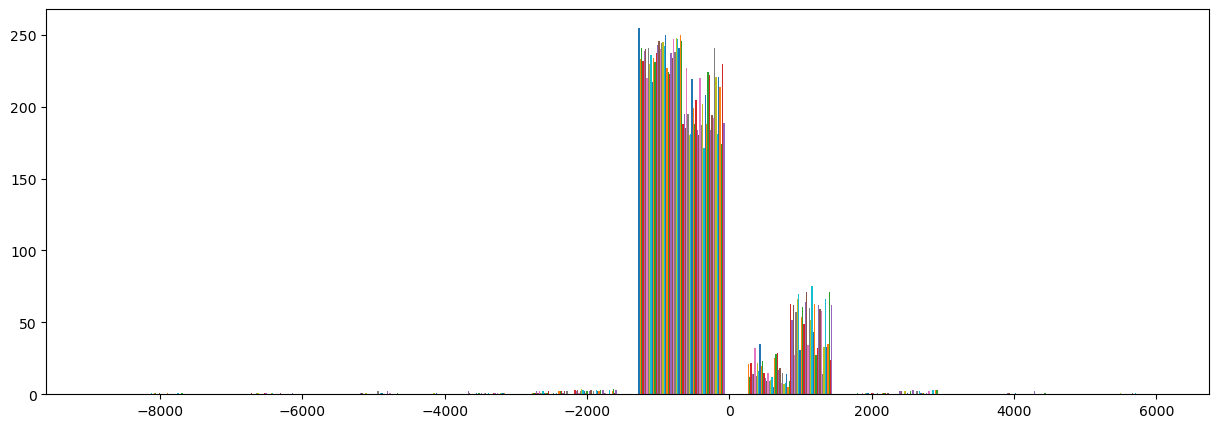

In [66]:
## normalized
plt.figure(figsize=(15,5))
plt.hist(total_differences);

In [68]:
output

array([0.        , 0.00392157, 0.00784314, 0.00392157, 0.        ,
       0.        , 0.01176471, 0.        , 0.01176471, 0.01176471,
       0.01176471, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.        , 0.        , 0.00784314, 0.        , 0.        ,
       0.        , 0.01176471, 0.01176471, 0.01176471, 0.00392157,
       0.00784314, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00784314, 0.02745098,
       0.02352941, 0.00392157, 0.00392157, 0.03137255, 0.01568627,
       0.01568627, 0.00784314, 0.01568627, 0.00392157, 0.02352941,
       0.01568627, 0.00392157, 0.03137255, 0.00392157, 0.03529412,
       0.01176471, 0.01568627, 0.00784314, 0.00392157, 0.03137255,
       0.00784314, 0.01960784, 0.        , 0.00392157, 0.02352941,
       0.00392157, 0.02352941, 0.02745098, 0.00392157, 0.01176471])

In [69]:
output[3]

0.00392156862745098

In [72]:
np.set_printoptions(precision=20)
np.unique(output)

array([0.                  , 0.00392156862745098 , 0.00784313725490196 ,
       0.011764705882352941, 0.01568627450980392 , 0.0196078431372549  ,
       0.023529411764705882, 0.027450980392156862, 0.03137254901960784 ,
       0.03529411764705882 ])

In [70]:
np.unique(output)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412])

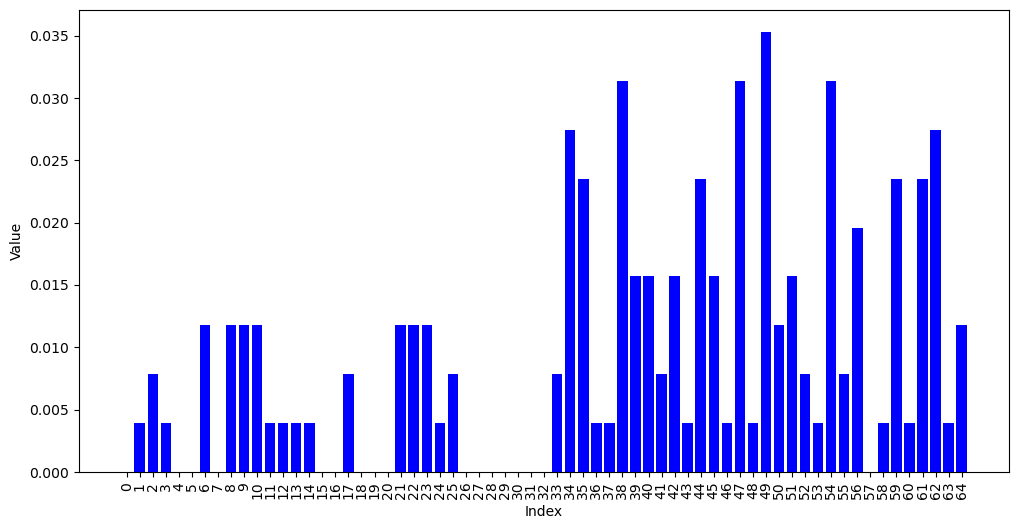

In [71]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(output)), output, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(range(len(output)))
plt.xticks(rotation=90)
plt.title('')
plt.show()

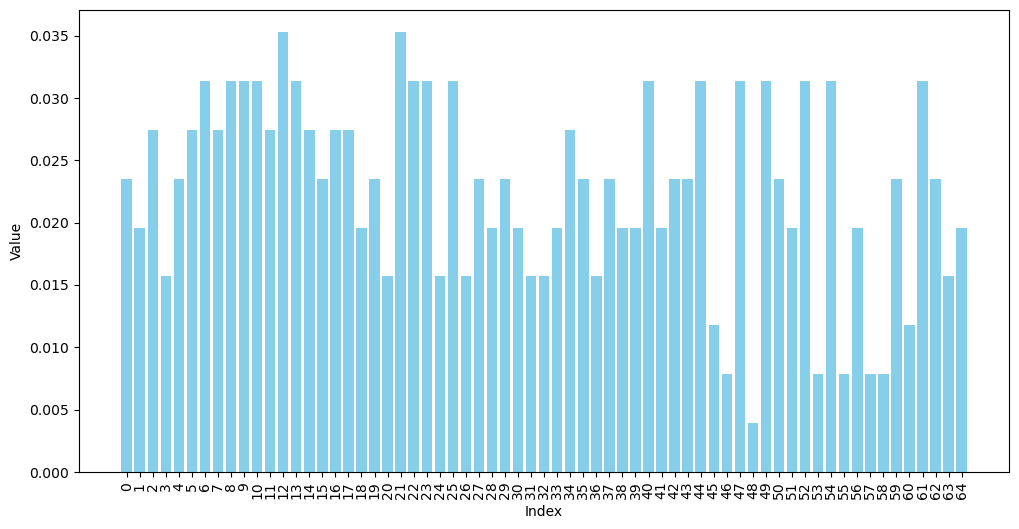

In [48]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(output)), output, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(range(len(output)))
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [26]:
# what are the indices of the features outside of the threshold
# np where returns a list of indices 
outliers = np.where((total_differences >= 0.5) | (total_differences <= -0.5))
outliers[1].shape

(376,)

In [49]:
outliers = np.where((output >= 0.030))
outliers

(array([ 6,  8,  9, 10, 12, 13, 21, 22, 23, 25, 40, 44, 47, 49, 52, 54, 61]),)

In [51]:
tmp = [ 6,  8,  9, 10, 12, 13, 21, 22, 23, 25, 40, 44, 47, 49, 52, 54, 61]
indices = [i+13 for i in tmp]
indices

[19, 21, 22, 23, 25, 26, 34, 35, 36, 38, 53, 57, 60, 62, 65, 67, 74]

In [23]:
np.unique(outliers[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [24]:
len(np.unique(outliers[1]))

65

In [27]:
total_differences.shape

(255, 65)

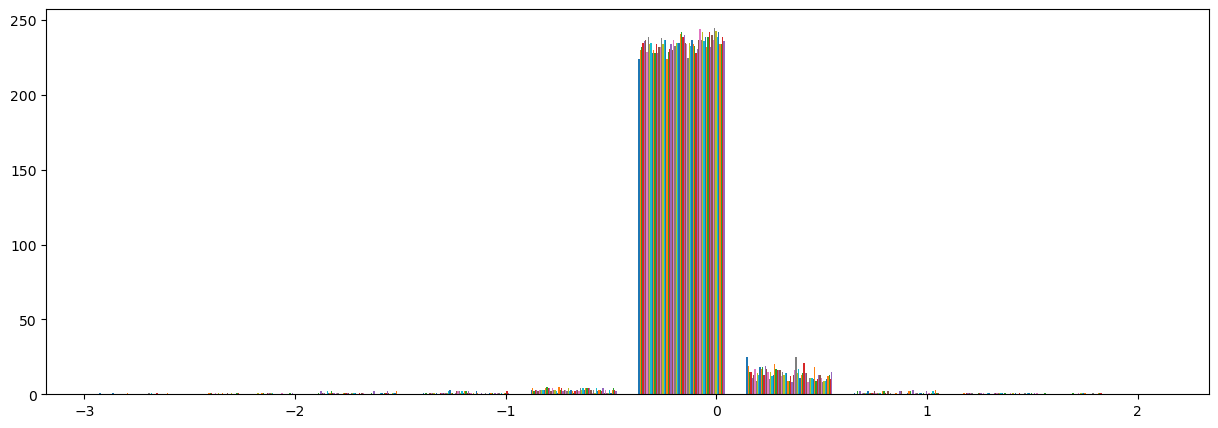

In [28]:
## normalized
plt.figure(figsize=(15,5))
plt.hist(total_differences);

In [30]:
total_differences.shape

(255, 65)